<a href="https://www.kaggle.com/code/sjain600/baseline-model-with-lightbm?scriptVersionId=233396840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

In [3]:
train.shape

(1200000, 21)

In [4]:
test.shape

(800000, 20)

In [5]:
train.head(10)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.59876067,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,<NA>,15.56973099,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.17754929,Suburban,Premium,1.0,14.0,<NA>,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,<NA>,10.93814416,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.37609363,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
5,5,29.0,Male,45963.0,Married,1.0,Bachelor's,<NA>,33.05319768,Urban,Premium,2.0,4.0,614.0,5.0,2022-05-20 15:21:39.207847,Average,No,Weekly,House,3202.0
6,6,41.0,Male,40336.0,Married,0.0,PhD,<NA>,<NA>,Rural,Basic,2.0,8.0,807.0,6.0,2020-02-21 15:21:39.219432,Poor,No,Weekly,House,439.0
7,7,48.0,Female,127237.0,Divorced,2.0,High School,Employed,5.769783093,Suburban,Comprehensive,1.0,11.0,398.0,5.0,2022-08-08 15:21:39.181605,Average,No,Rarely,Condo,111.0
8,8,21.0,Male,1733.0,Divorced,3.0,Bachelor's,<NA>,17.86955081,Urban,Premium,1.0,10.0,685.0,8.0,2020-12-14 15:21:39.198406,Average,No,Monthly,Condo,213.0
9,9,44.0,Male,52447.0,Married,2.0,Master's,Employed,20.47371786,Urban,Comprehensive,1.0,9.0,635.0,3.0,2020-08-02 15:21:39.144722,Poor,No,Daily,Condo,64.0


In [6]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
train['year'] = train['Policy Start Date'].dt.year.astype('float32')
train['month'] = train['Policy Start Date'].dt.month.astype('float32')
train['day'] = train['Policy Start Date'].dt.day.astype('float32')
train['day_of_week'] = train['Policy Start Date'].dt.day_of_week.astype('float32')
train['seconds'] = (train['Policy Start Date'].astype(int) // 10**9).astype('float32')
train.drop('Policy Start Date', axis=1, inplace=True)

In [7]:
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['year'] = test['Policy Start Date'].dt.year.astype('float32')
test['month'] = test['Policy Start Date'].dt.month.astype('float32')
test['day'] = test['Policy Start Date'].dt.day.astype('float32')
test['day_of_week'] = test['Policy Start Date'].dt.day_of_week.astype('float32')
test['seconds'] = (test['Policy Start Date'].astype(int) // 10**9).astype('float32')
test.drop('Policy Start Date', axis=1, inplace=True)

## EDA

In [8]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,year,month,day,day_of_week,seconds
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,2023.0,12.0,23.0,5.0,1.703345e+09
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,<NA>,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,2023.0,6.0,12.0,0.0,1.686583e+09
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,<NA>,3.0,Good,Yes,Weekly,House,567.0,2023.0,9.0,30.0,5.0,1.696087e+09
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,<NA>,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,765.0,2024.0,6.0,12.0,2.0,1.718206e+09
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,Poor,Yes,Weekly,House,2022.0,2021.0,12.0,1.0,2.0,1.638372e+09


In [9]:
train.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
year                         0
month                        0
day                          0
day_of_week                  0
seconds                      0
dtype: int64

In [10]:
test.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
year                         0
month                        0
day                          0
day_of_week                  0
seconds                      0
dtype: int64

In [11]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   id                    1200000 non-null  int64
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object
 7   Occupation            841925 non-null   object
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object
 10  Policy Type           1200000 non-null  object
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-null  floa

## Data Preprocessing

In [12]:
from sklearn.impute import SimpleImputer

simple = SimpleImputer(strategy='most_frequent')
cat_cols = train.select_dtypes(include='object').columns
train[cat_cols] = simple.fit_transform(train[cat_cols])
test[cat_cols] = simple.transform(test[cat_cols])

In [13]:
from category_encoders import CountEncoder

ce = CountEncoder()
train[cat_cols] = ce.fit_transform(train[cat_cols])
test[cat_cols] = ce.transform(test[cat_cols])

In [14]:
simple = SimpleImputer(strategy='median')
num_cols = test.select_dtypes(exclude='object').columns
train[num_cols] = simple.fit_transform(train[num_cols])
test[num_cols] = simple.transform(test[num_cols])

## Identifying outliers

<Axes: ylabel='Premium Amount'>

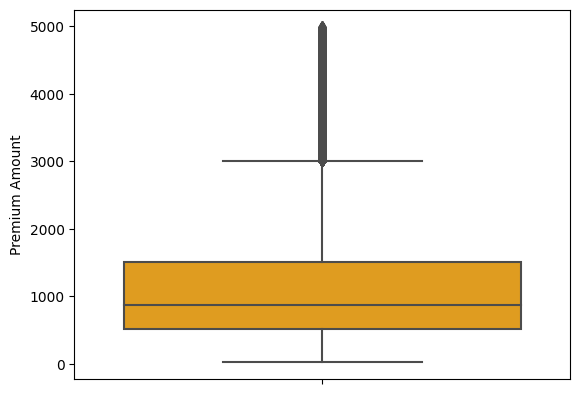

In [15]:
sns.boxplot(data=train, y='Premium Amount', color='orange')

## Splitting the data for model prediction

In [16]:
from sklearn.model_selection import KFold

X = train.copy()
y = X.pop('Premium Amount')
y = np.log(y)

X_test = test.copy()

kf = KFold(n_splits=10, random_state=340, shuffle=True)
for train_index, valid_index in kf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    

## LightGBM

In [17]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

lgm = LGBMRegressor(random_state=340, verbose=-1).fit(X_train, y_train)
preds_light = lgm.predict(X_valid)
print(f'RMSLE: {np.sqrt(mean_squared_log_error(preds_light, y_valid)):,.5f}')

RMSLE: 0.15986


In [18]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 8.0),
        'max_depth': trial.suggest_int('max_depth', 1, 13),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 15, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'verbose': -1,
        'random_state': 340,
        'metric': 'rmse',
        'n_jobs': -1,
        'device': 'gpu',
    }

    lgm = LGBMRegressor(**params)
    score = -1 * cross_val_score(lgm, X_train, y_train, scoring='neg_mean_squared_log_error').mean()
    rmsle = np.sqrt(score)
    return rmsle

study = optuna.create_study(direction='minimize', study_name='LGM-RMSE-Optimization')
study.optimize(objective, n_trials=10)

print(f'Best cross-validation RMSE: {study.best_value:,.4f}')
print(f'Best parameters: {study.best_params}')

[I 2025-04-12 04:57:18,798] A new study created in memory with name: LGM-RMSE-Optimization
[I 2025-04-12 04:58:53,309] Trial 0 finished with value: 0.16185687456853012 and parameters: {'n_estimators': 576, 'learning_rate': 0.0028800057188667237, 'min_split_gain': 7.761846217701929, 'max_depth': 10, 'reg_lambda': 1.5792532510968675, 'feature_fraction': 0.6847999566621008}. Best is trial 0 with value: 0.16185687456853012.
[I 2025-04-12 04:59:46,152] Trial 1 finished with value: 0.1599102299794608 and parameters: {'n_estimators': 749, 'learning_rate': 0.024740979967493023, 'min_split_gain': 4.676913906620704, 'max_depth': 11, 'reg_lambda': 10.169692267404253, 'feature_fraction': 0.7360787486291172}. Best is trial 1 with value: 0.1599102299794608.
[I 2025-04-12 05:00:32,232] Trial 2 finished with value: 0.16004346695425753 and parameters: {'n_estimators': 441, 'learning_rate': 0.024124933686229453, 'min_split_gain': 5.924924719519894, 'max_depth': 6, 'reg_lambda': 0.04156673531021484, 'fea

Best cross-validation RMSE: 0.1599
Best parameters: {'n_estimators': 711, 'learning_rate': 0.03382675463705338, 'min_split_gain': 5.518574743068189, 'max_depth': 11, 'reg_lambda': 2.12648373586283, 'feature_fraction': 0.798207251682957}


## Submission

In [19]:
test_preds = lgm.predict(X_test)
sub = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
sub['Premium Amount'] = np.exp(test_preds) - 1
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
sub.head()

Your submission was successfully saved!


,id,Premium Amount
0,1200000,778.974759
1,1200001,840.737173
2,1200002,812.081231
3,1200003,812.758608
4,1200004,771.789476
